# Building a Hybrid RAG System with PydanticAI and MongoDB: Creating an AI Agent for Tech News Search and Retrieval



---

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mongodb-developer/GenAI-Showcase/blob/main/notebooks/agents/ai_agent_with_pydanticai_and_mongodb.ipynb)

[![Watch on YouTube](https://img.youtube.com/vi/2HPQKIGwQV0/hqdefault.jpg)](https://www.youtube.com/watch/2HPQKIGwQV0?si=Kvlm_VmqWS1J4YTxQ)


This project demonstrates how to build an intelligent information retrieval system that combines local vector search with real-time internet search capabilities. The system addresses a critical challenge in AI applications: providing accurate, up-to-date information while maintaining high performance and reliability.

Core Problem and Solution:

Traditional language models often provide outdated information, while pure internet search lacks semantic understanding. This hybrid RAG system solves this by combining a MongoDB vector database for historical tech news with real-time internet search through Tavily, ensuring both speed and freshness of information.

---

Real-World Applications:
- **Enterprise Intelligence**: Companies like Microsoft or Google could use this to track competitor activities and market trends, combining historical data with breaking news.

- **Financial Analysis**: Investment firms could monitor market movements and company developments, getting both archived research and current announcements about topics like "recent developments in EV technology."

- **Research Monitoring**: Research institutions could track scientific developments, accessing both established research and recent breakthroughs in fields like quantum computing or AI.

---

What makes this implementation particularly powerful is its use of modern tools and practices:

- Pydantic provides robust type safety and validation
- PydanticAI for implementing ai agents with access to system tools
- MongoDB's vector search capabilities enable efficient semantic search
- Tavily for internet search and implementing HybridRAG
- The hybrid RAG approach combines the benefits of both local and internet search
- Dependency injection patterns make the system maintainable and testable

---

Glossary:
- Agents
- RAG
- Agentic RAG
- Control Flow
- HybridRAG

## Step 1: Installing Libaries and Environment Variables





In [4]:
!pip install -U --quiet pydantic-ai pymongo datasets pandas tavily-python

Let's break down why we need each of these packages:

- `pydantic-ai`: This is our framework for building type-safe AI agents. It provides the scaffolding for creating reliable, maintainable AI applications with proper dependency injection and error handling.
- `pymongo`: Our interface to MongoDB, which will serve as both our vector database and operational data store. We'll use it to store and retrieve embeddings for semantic search.
- `datasets`: Hugging Face's datasets library, which we'll use to load our initial tech news dataset. This gives us a solid foundation of data to work with and use as the knowledge base for the agent.
- `pandas`: The Swiss Army knife of data manipulation in Python. We'll use it to process and transform our data before storage.
- `tavily-python`: A powerful search client that will enable our system to perform real-time internet searches, complementing our local vector search capabilities.



> Note: As of the publshing of this notebook, PydanticAI is in early beta.

In [5]:
import getpass
import os


# Function to securely get and set environment variables
def set_env_securely(var_name, prompt):
    value = getpass.getpass(prompt)
    os.environ[var_name] = value

In [6]:
# Get your OpenAI Key: https://platform.openai.com/api-keys
set_env_securely("OPENAI_API_KEY", "Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


## Step 2: Creating a Simple Agent with PydanticAI and OpenAI


The first major component we need to understand is the AI agent itself. This agent will be the orchestrator of our entire system, handling everything from query processing to result generation.


*An agent is a computational entity composed of several integrated components, including the brain(llm), perception(environment) and action components(tools). These components work cohesively to enable the agent to achieve its defined objectives and goals.*

Read more [here](https://www.mongodb.com/resources/basics/artificial-intelligence/ai-agents)

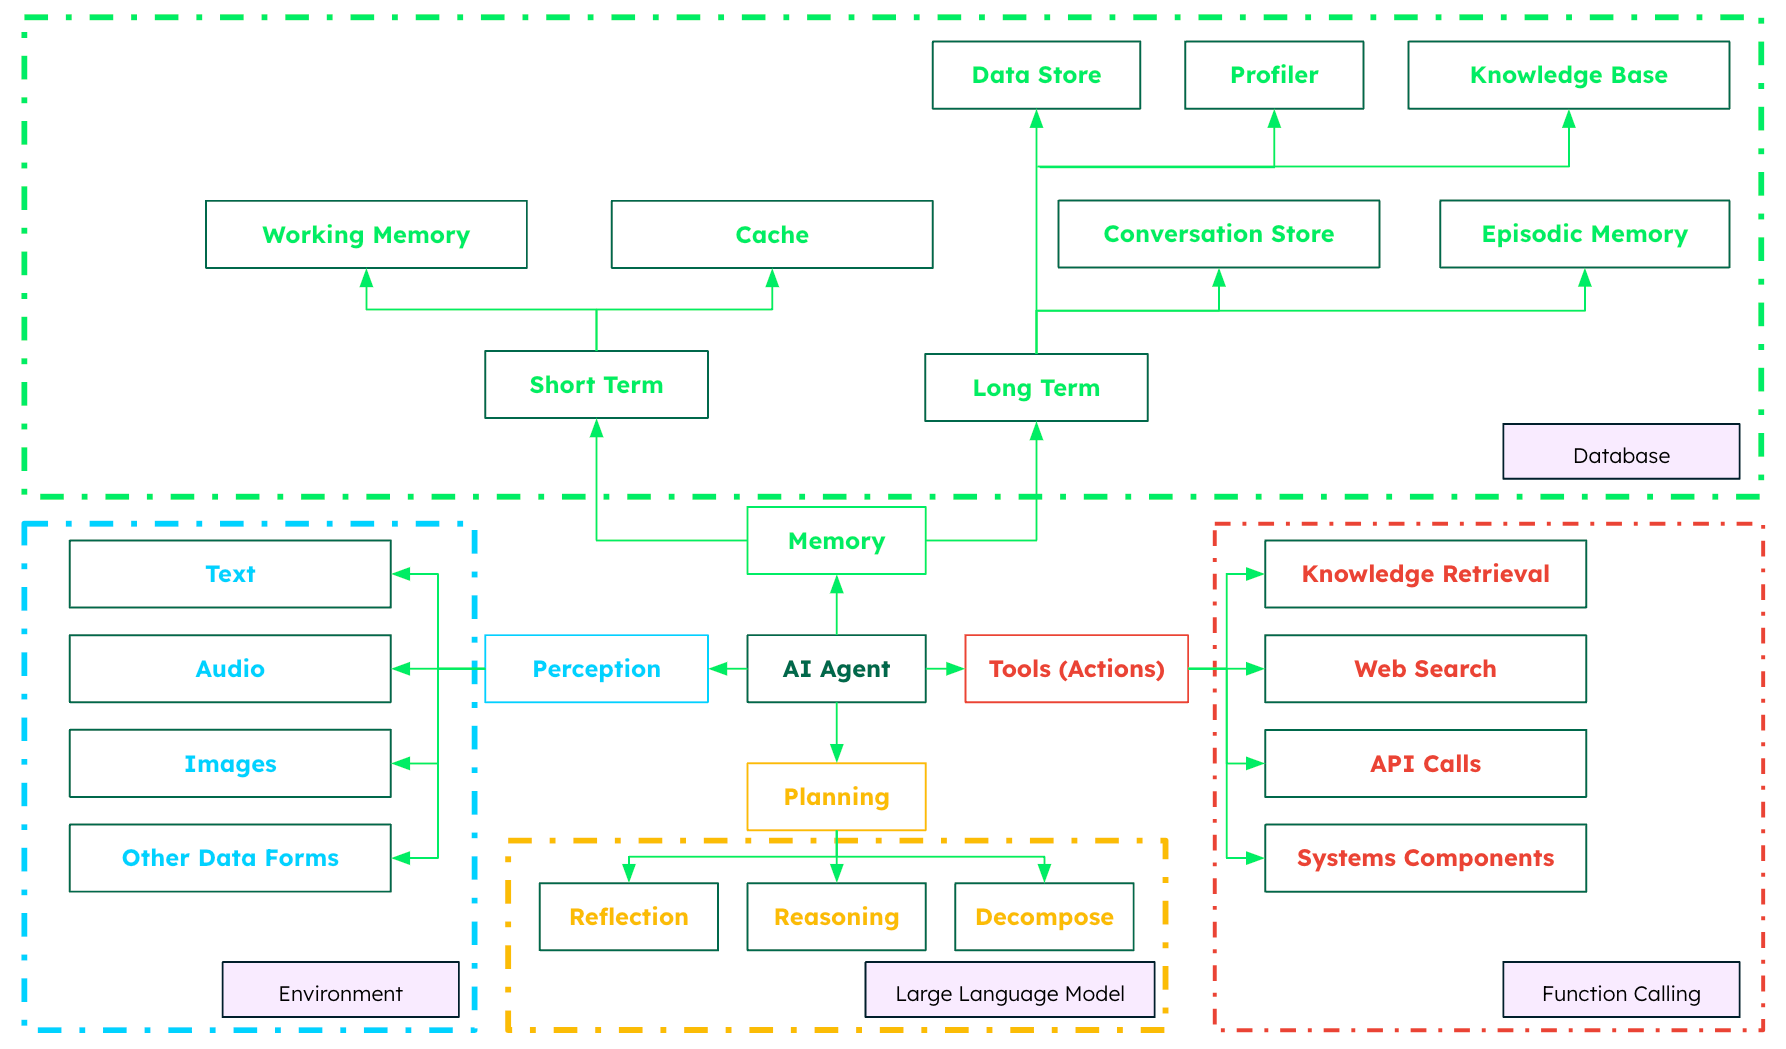

In [7]:
import nest_asyncio
from pydantic_ai import Agent
from pydantic_ai.models.openai import OpenAIModel

# Apply nest_asyncio patch to allow nested event loops
nest_asyncio.apply()

model = OpenAIModel("gpt-4o")

agent = Agent(
    model,
    system_prompt="When provided with a sentence, simulate shouting",
)

In modern Python applications, especially those dealing with AI and real-time data processing, we often work with asynchronous operations. However, when working in environments like Jupyter notebooks or when dealing with nested event loops, we can run into limitations with Python's default asyncio implementation.

The line `nest_asyncio.apply()` solves this by allowing nested event loops to run. Think of it like giving your code the ability to multitask within multitasking – it's essential for complex applications that need to handle multiple asynchronous operations simultaneously.


---



**Pydantic AI Approach to Agents**

When building AI applications, one of the most crucial components is managing interactions with language models in a structured, type-safe way. PydanticAI's Agent system provides exactly this, offering a robust framework for creating AI-powered applications.

A high level way of conceptualizing an Agent `Agent()` is to imagine a wrapper around an LLM `model = OpenAIModel('gpt-4o')` that converts the LLM into a system compoents with additional components such as:

- System Prompts: Instructions that guide the LLM's behavior
- Function Tools: Custom functions the LLM can call during execution
- Structured Result Types: Defined output formats
- Dependencies: Resources needed during execution
- Model Settings: Configuration for fine-tuning responses

We will talk more on dependencies and other components in later section of this notebook. But in the code above we pass the `model` and `system_prompt` arguments. These are the only component we need for a basic level Agent using Pydantic.

For our basic Agent, it will take a user input and then convert it into uppercase letters to simulate shouting


In [8]:
result = agent.run_sync("this sentence started off initially quieter")
print(result.data)

THIS SENTENCE STARTED OFF INITIALLY QUIETER!


There are three main ways to execute an agent in Pydantic AI:

1. `agent.run()`: This is used in asynchronous contexts where you want to await a single complete response. It returns a coroutine that resolves to a RunResult containing the agent's full response. Ideal for async web applications or when integrating with other async code.

2. `agent.run_sync()`: This is used in synchronous contexts where you want a simple, blocking call that returns a complete response. It's essentially a wrapper around run() that handles the async/sync conversion for you. Perfect for scripts, notebooks, or synchronous applications where you need a straightforward way to get results. This is the one we use in the example above.

3. `agent.run_stream()`: This is used when you want to receive the agent's response in chunks as they become available. It returns a StreamedRunResult that can be iterated over asynchronously, making it ideal for real-time applications, chat interfaces, or when dealing with long responses where you want to show progressive updates to users.

And that's how simple it is to build an Agent with Pydantic AI. It's very straightforward yet powerful, offering type safety, dependency injection(shown later), and flexible execution methods all in one package.

While the basic setup can be as simple as defining a model and system prompt, the framework scales elegantly to handle complex use cases like our hybrid RAG system.

The combination of Python's type system with PydanticAI's structured approach to AI agent development makes it an excellent choice for building production-ready AI applications that are both maintainable and reliable.

Next, let's give our Agent some knowledge.

## Step 3: Data Loading and Preparation

One of the first steps in building a robust RAG system is establishing a solid knowledge base. Let's explore how to efficiently load and process data from Hugging Face's datasets library, specifically focusing on a tech news embeddings dataset.

To further enhance the dataset's utility, there is an e,embedding attribute for each data point that has a vector embedding created using the OpenAI EMBEDDING_MODEL = "text-embedding-3-small", with an EMBEDDING_DIMENSION of 256.





In [9]:
import pandas as pd
from datasets import load_dataset

# Ensure you have an HF_TOKEN in your environment variable
# https://huggingface.co/datasets/MongoDB/tech-news-embeddings
ds = load_dataset("MongoDB/tech-news-embeddings", split="train", streaming=True)

dataset_segment = ds.take(10000)

dataset_df = pd.DataFrame(dataset_segment)

Resolving data files:   0%|          | 0/42 [00:00<?, ?it/s]

The code snippet above retrieves data from the Hugging Face dataset repository, specifically, the MongnoDB tech_embeddings dataset available [here](https://huggingface.co/datasets/MongoDB/tech-news-embeddings).


- Streaming Mode: By setting `streaming=True`, we enable efficient memory handling for large datasets. Instead of loading everything at once, we can process data in chunks.

- Split Selection: Using `split="train"` specifies which portion of the dataset we want to access.

- Memory Management: `ds.take(10000)` allows us to work with a subset of data. You can increase this as you see fit. The limitation primarly prevents memory overflow issues with large datasets. The full tech embeddings dataset contains 1,576,528 data points.


> Note: best practices for when working with datasets for RAG systems is to start small. Begin with a manageable subset to validate your pipeline and then incrementally increase size once core functionality is verified




In [10]:
# Observe top data points
dataset_df.head()

,_id,companyName,companyUrl,published_at,url,title,main_image,description,embedding
0,65c63ea1f187c085a866f680,01Synergy,https://hackernoon.com/company/01synergy,2023-05-16 02:09:00,https://www.businesswire.com/news/home/2023051...,onsemi and Sineng Electric Spearhead the Devel...,https://firebasestorage.googleapis.com/v0/b/ha...,(Nasdaq: ON) a leader in intelligent power and...,"[0.05243798345327377, -0.10347484797239304, -0..."
1,65c63ea2f187c085a866f681,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 00:07:00,https://elkodaily.com/news/local/adobe-student...,Adobe student receives national Information an...,https://firebasestorage.googleapis.com/v0/b/ha...,ELKO — An eighth grader at Adobe Middle School...,"[0.0036485784221440554, -0.05992984399199486, ..."
2,65c63ea2f187c085a866f682,01Synergy,https://hackernoon.com/company/01synergy,2023-05-01 22:22:00,https://www.aei.org/technology-and-innovation/...,Modernizing State Services: Harnessing Technol...,https://firebasestorage.googleapis.com/v0/b/ha...,To deliver 21st-century government services Go...,"[0.012319465167820454, -0.0807630866765976, 0...."
3,65c63ea2f187c085a866f683,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 13:12:00,https://www.crn.com/news/managed-services/terr...,Terry Richardson On Why He Left AMD GreenPages...,https://firebasestorage.googleapis.com/v0/b/ha...,In February GreenPages acquired Toronto-based ...,"[-0.02363203465938568, 0.021521812304854393, 0..."
4,65c63ea7f187c085a866f684,01Synergy,https://hackernoon.com/company/01synergy,2023-05-15 20:01:00,https://www.benzinga.com/pressreleases/23/05/3...,Synex Renewable Energy Corporation (Formerly S...,https://firebasestorage.googleapis.com/v0/b/ha...,The conference will bring together growth orie...,"[0.08473014086484909, -0.07019763439893723, 0...."


In [11]:
# Remove the _id field
dataset_df = dataset_df.drop(columns=["_id"])

# Observe top data points
dataset_df.head()

,companyName,companyUrl,published_at,url,title,main_image,description,embedding
0,01Synergy,https://hackernoon.com/company/01synergy,2023-05-16 02:09:00,https://www.businesswire.com/news/home/2023051...,onsemi and Sineng Electric Spearhead the Devel...,https://firebasestorage.googleapis.com/v0/b/ha...,(Nasdaq: ON) a leader in intelligent power and...,"[0.05243798345327377, -0.10347484797239304, -0..."
1,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 00:07:00,https://elkodaily.com/news/local/adobe-student...,Adobe student receives national Information an...,https://firebasestorage.googleapis.com/v0/b/ha...,ELKO — An eighth grader at Adobe Middle School...,"[0.0036485784221440554, -0.05992984399199486, ..."
2,01Synergy,https://hackernoon.com/company/01synergy,2023-05-01 22:22:00,https://www.aei.org/technology-and-innovation/...,Modernizing State Services: Harnessing Technol...,https://firebasestorage.googleapis.com/v0/b/ha...,To deliver 21st-century government services Go...,"[0.012319465167820454, -0.0807630866765976, 0...."
3,01Synergy,https://hackernoon.com/company/01synergy,2023-05-02 13:12:00,https://www.crn.com/news/managed-services/terr...,Terry Richardson On Why He Left AMD GreenPages...,https://firebasestorage.googleapis.com/v0/b/ha...,In February GreenPages acquired Toronto-based ...,"[-0.02363203465938568, 0.021521812304854393, 0..."
4,01Synergy,https://hackernoon.com/company/01synergy,2023-05-15 20:01:00,https://www.benzinga.com/pressreleases/23/05/3...,Synex Renewable Energy Corporation (Formerly S...,https://firebasestorage.googleapis.com/v0/b/ha...,The conference will bring together growth orie...,"[0.08473014086484909, -0.07019763439893723, 0...."


PydanticAI is created by the team that made Pydantic, which we will use to ensure data integrity and type safety throughout our application.

Below we create a data model `TechNewsData`. This structured approach to data modeling helps prevent bugs early in the development process and makes your code more maintainable. As your RAG system grows, having these strong type guarantees becomes increasingly valuable.


In [12]:
from typing import List, Optional

from pydantic import BaseModel, Field


class TechNewsData(BaseModel):
    companyName: str
    companyUrl: str
    published_at: str
    title: str
    description: str
    url: str
    embedding: List[float] = Field(
        ..., description="The embedding vector for the news article"
    )

The benefits of using Pydantic models in your RAG system are threefold:

1. you get robust type safety with automatic validation, clear contracts, and IDE autocompletion; serialization capabilities that make JSON conversion and MongoDB integration effortless while maintaining clean API interfaces;

2. and comprehensive documentation features including self-documenting code, clear field descriptions,

3. and automatic schema generation, all of which contribute to making your codebase more maintainable and developer-friendly.



In [13]:
# Conform every datapoint to the TechNewsData model
dataset_df = dataset_df.apply(
    lambda x: TechNewsData(**x.to_dict()).model_dump(), axis=1
)

## Step 4: Defining Embedding Function

When building a RAG (Retrieval Augmented Generation) system, one of the fundamental components is converting text into vector embeddings. These embeddings allow us to perform semantic search, finding similar content based on meaning rather than just matching keywords. Let's look at how to implement this using OpenAI's embedding API.


In [14]:
import openai

client = openai.OpenAI()
DIMENSION_SIZE = 256


def get_embeddings(
    texts: list[str], doc_type: str = "search_query"
) -> list[list[float]]:
    """
    Generate embeddings for a list of input texts.

    Args:
        texts: List of strings to generate embeddings for
        doc_type: Type of document being embedded (default: "search_query")

    Returns:
        List of embeddings, where each embedding is a list of floats
    """
    # Create embeddings for all texts in a single API call
    response = client.embeddings.create(
        input=texts, model="text-embedding-3-small", dimensions=DIMENSION_SIZE
    )

    # Extract embeddings from response
    embeddings = [data.embedding for data in response.data]

    return embeddings

Embeddings are generated from a list of string input as shown in the example below:
```
# Example usage in a real-world scenario
news_articles = [
    "OpenAI releases GPT-5",
    "New advancements in quantum computing",
    "Latest developments in AI ethics"
]

```

The embedding model used is `text-embedding-3-small`, OpenAI's latest embedding model optimized for efficient semantic search and text similarity tasks. This model offers a good balance between performance and cost, making it suitable for RAG applications.

By setting a constant `DIMENSION_SIZE`, we ensure all our embeddings have consistent dimensions. This is crucial when working with vector databases and performing similarity searches. Consistent dimensions are essential because:

They enable efficient vector operations
They ensure compatibility across your database
They allow for predictable memory usage and indexing

The dimension size for this notebook is `256`, which is relatively small, and for production scenarios, larger dimension sizes can be used to capture more semantics within the data.

When choosing dimension size, consider:

- Your specific use case requirements
- Available computational resources
- Storage capacity
- Query performance needs
- Cost considerations

For many applications, 256 dimensions provide a good starting point for prototyping and testing your RAG system before scaling up to larger dimensions in production.

Read these articles for more information on [choosing embedding models](https://www.mongodb.com/developer/products/atlas/choose-embedding-model-rag/) and [chunking stratgeies](https://www.mongodb.com/developer/products/atlas/choosing-chunking-strategy-rag/)


## Step 5: MongoDB (Operational and Vector Database)

MongoDB acts as both an operational and vector database for the RAG system.
MongoDB Atlas specifically provides a database solution that efficiently stores, queries and retrieves vector embeddings.

Creating a database and collection within MongoDB is made simple with MongoDB Atlas.

1. First, register for a [MongoDB Atlas account](https://www.mongodb.com/cloud/atlas/register). For existing users, sign into MongoDB Atlas.
2. [Follow the instructions](https://www.mongodb.com/docs/atlas/tutorial/deploy-free-tier-cluster/). Select Atlas UI as the procedure to deploy your first cluster.

Follow MongoDB’s [steps to get the connection](https://www.mongodb.com/docs/manual/reference/connection-string/) string from the Atlas UI. After setting up the database and obtaining the Atlas cluster connection URI, securely store the URI within your development environment.


In [15]:
# Set MongoDB URI
set_env_securely("MONGO_URI", "Enter your MONGO URI: ")

Enter your MONGO URI: ··········


In [16]:
import pymongo


def get_mongo_client(mongo_uri):
    """Establish and validate connection to the MongoDB."""

    client = pymongo.MongoClient(
        mongo_uri, appname="devrel.showcase.agents.pydanticai.python"
    )

    # Validate the connection
    ping_result = client.admin.command("ping")
    if ping_result.get("ok") == 1.0:
        # Connection successful
        print("Connection to MongoDB successful")
        return client
    else:
        print("Connection to MongoDB failed")
    return None


MONGO_URI = os.environ["MONGO_URI"]
if not MONGO_URI:
    print("MONGO_URI not set in environment variables")

Let's explore how to properly set up and manage MongoDB collections for our RAG system's knowledge base. This setup is crucial for storing and retrieving our vectorized news articles description+title efficiently.


In [17]:
from pymongo.errors import CollectionInvalid

mongo_client = get_mongo_client(MONGO_URI)

DB_NAME = "tech_news_agent"
COLLECTION_NAME = "knowledge_base"

# Create or get the database
db = mongo_client[DB_NAME]

# Check if the collection exists
if COLLECTION_NAME not in db.list_collection_names():
    try:
        # Create the collection
        db.create_collection(COLLECTION_NAME)
        print(f"Collection '{COLLECTION_NAME}' created successfully.")
    except CollectionInvalid as e:
        print(f"Error creating collection: {e}")
else:
    print(f"Collection '{COLLECTION_NAME}' already exists.")

# Assign the collection
knowledge_base = db[COLLECTION_NAME]

Connection to MongoDB successful
Collection 'knowledge_base' created successfully.


When building a RAG system, proper database setup is crucial for managing your knowledge base effectively.

Our implementation uses MongoDB, a general purpose database that's particularly well-suited for handling document-based data and vector embeddings.

The code snippet above establishes a connection to MongoDB through the `get_mongo_client` function, then sets up a database named "tech_news_agent" with a collection called "knowledge_base".

We implement a robust error-handling pattern that checks if the collection exists before attempting to create it, catching any `CollectionInvalid` exceptions that might occur during the process. This idempotent approach means the code can be run multiple times safely – if the collection already exists, it simply connects to it; if not, it creates it.

The clear naming conventions (like `tech_news_agent` for the database and `knowledge_base` for the collection) make the code's purpose immediately apparent and easier to maintain. Finally, we assign the collection to a `knowledge_base` variable, which we'll use throughout our application for storing and retrieving vectorized news articles. This foundation ensures our RAG system has a reliable and efficient data storage layer, ready for implementing vector search capabilities and managing our embedded documents.

## Step 6: Data Ingestion

In [18]:
knowledge_base.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff000000000000003a'), 'opTime': {'ts': Timestamp(1736447697, 1), 't': 58}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1736447697, 1), 'signature': {'hash': b'\x06\xb1\xdb^\xd2cP\xf5xs\xba\xc42x\x91\xf1\x862\x9bM', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1736447697, 1)}, acknowledged=True)

**Why MongoDB for AI Workloads?**

MongoDB, offers several compelling advantages for AI workloads, particularly in simplifying data ingestion.

The code snippet below demonstrates how MongoDB streamlines the data ingestion process by eliminating the need for explicit serialization and deserialization.

In [19]:
documents = [TechNewsData(**x).model_dump() for x in dataset_df]

In [20]:
knowledge_base.insert_many(documents)
print("Data ingestion into MongoDB completed")

Data ingestion into MongoDB completed


##Step 7: Vector Search Index Creation

In [21]:
import time

from pymongo.operations import SearchIndexModel


def setup_vector_search_index(collection, index_definition, index_name="vector_index"):
    """
    Setup a vector search index for a MongoDB collection and wait for 30 seconds.

    Args:
    collection: MongoDB collection object
    index_definition: Dictionary containing the index definition
    index_name: Name of the index (default: "vector_index")
    """
    new_vector_search_index_model = SearchIndexModel(
        definition=index_definition, name=index_name, type="vectorSearch"
    )

    # Create the new index
    try:
        result = collection.create_search_index(model=new_vector_search_index_model)
        print(f"Creating index '{index_name}'...")

        # Sleep for 60 seconds
        print(f"Waiting for 60 seconds to allow index '{index_name}' to be created...")
        time.sleep(30)

        print(f"60-second wait completed for index '{index_name}'.")
        return result

    except Exception as e:
        print(f"Error creating new vector search index '{index_name}': {e!s}")
        return None

In [22]:
def create_vector_index_definition():
    # Define the field types
    base_fields = [
        {
            "type": "vector",
            "path": "embedding",  # Ensure this matches the name of the attribute containing vector embeddings in your dataset
            "numDimensions": DIMENSION_SIZE,
            "similarity": "cosine",
        }
    ]

    return {"fields": base_fields}

In [23]:
vector_index_definition = create_vector_index_definition()

In [24]:
print(vector_index_definition)

{'fields': [{'type': 'vector', 'path': 'embedding', 'numDimensions': 256, 'similarity': 'cosine'}]}


In [25]:
setup_vector_search_index(knowledge_base, vector_index_definition, "vector_index")

Creating index 'vector_index'...
Waiting for 60 seconds to allow index 'vector_index' to be created...
60-second wait completed for index 'vector_index'.


'vector_index'

## Step 8: Vector Search Operation

In [26]:
def custom_vector_search(
    user_query: list[str],
    collection,
    embedding_path="embedding",
    vector_search_index_name="vector_index",
):
    """
    Perform a vector search in the MongoDB collection based on the user query.

    Args:
        user_query (str): The user's query string.
        collection (MongoCollection): The MongoDB collection to search.
        embedding_path (str): The path of the embedding field in the documents.
        vector_search_index_name (str): The name of the vector search index.

    Returns:
        list: A list of matching documents.
    """

    # Generate embedding for the user query
    query_embedding = get_embeddings(user_query)[0]

    if query_embedding is None:
        return "Invalid query or embedding generation failed."

    # Define the vector search stage
    vector_search_stage = {
        "$vectorSearch": {
            "index": vector_search_index_name,  # Specifies the index to use for the search
            "queryVector": query_embedding,  # The vector representing the query
            "path": embedding_path,  # Field in the documents containing the vectors to search against
            "numCandidates": 20,  # Number of candidate matches to consider
            "limit": 5,  # Return top 5 matches
        }
    }

    project_stage = {
        "$project": {
            "_id": 0,  # Exclude the _id field
            "title": 1,  # Include the title field,
            "companyName": 1,  # Include the companyName field,
            "companyUrl": 1,  # Include the companyUrl field,
            "published_at": 1,  # Include the published_at field,
            "description": 1,  # Include the description field
            "url": 1,  # Include the url field
            "score": {
                "$meta": "vectorSearchScore"  # Include the search score
            },
        }
    }

    # Define the aggregate pipeline with the vector search stage and additional stages
    pipeline = [vector_search_stage, project_stage]

    # Execute the explain command
    explain_result = collection.database.command(
        "explain",
        {"aggregate": collection.name, "pipeline": pipeline, "cursor": {}},
        verbosity="executionStats",
    )

    # Extract the execution time
    vector_search_explain = explain_result["stages"][0]["$vectorSearch"]
    execution_time_ms = vector_search_explain["explain"]["query"]["stats"]["context"][
        "millisElapsed"
    ]

    # Execute the actual query
    results = list(collection.aggregate(pipeline))

    return results, execution_time_ms

In [27]:
results, time = custom_vector_search(
    ["Get me some news on electric cars if possible"], knowledge_base
)

In [28]:
import pprint

pprint.pprint(results)

[{'companyName': '10Clouds',
  'companyUrl': 'https://hackernoon.com/company/10clouds',
  'description': 'Find insight on Aerojet Rocketdyne Appen and more in the '
                 'latest Market Talks covering Technology Media and Telecom.',
  'published_at': '2023-03-17 10:52:00',
  'score': 0.7128037214279175,
  'title': 'Tech Media & Telecom Roundup: Market Talk',
  'url': 'https://www.wsj.com/articles/tech-media-telecom-roundup-market-talk-8105659d'},
 {'companyName': '10Clouds',
  'companyUrl': 'https://hackernoon.com/company/10clouds',
  'description': 'Find insight on LONGi Green Energy Technology Auto Trader '
                 'and more in the latest Market Talks covering the Technology '
                 'Media and Telecom sector.',
  'published_at': '2023-06-01 11:07:00',
  'score': 0.7083801031112671,
  'title': 'Tech Media & Telecom Roundup: Market Talk',
  'url': 'https://www.wsj.com/articles/tech-media-telecom-roundup-market-talk-8306f871'},
 {'companyName': '10Clouds',

## Step 9: Creating PydanticAI Agents with Tools

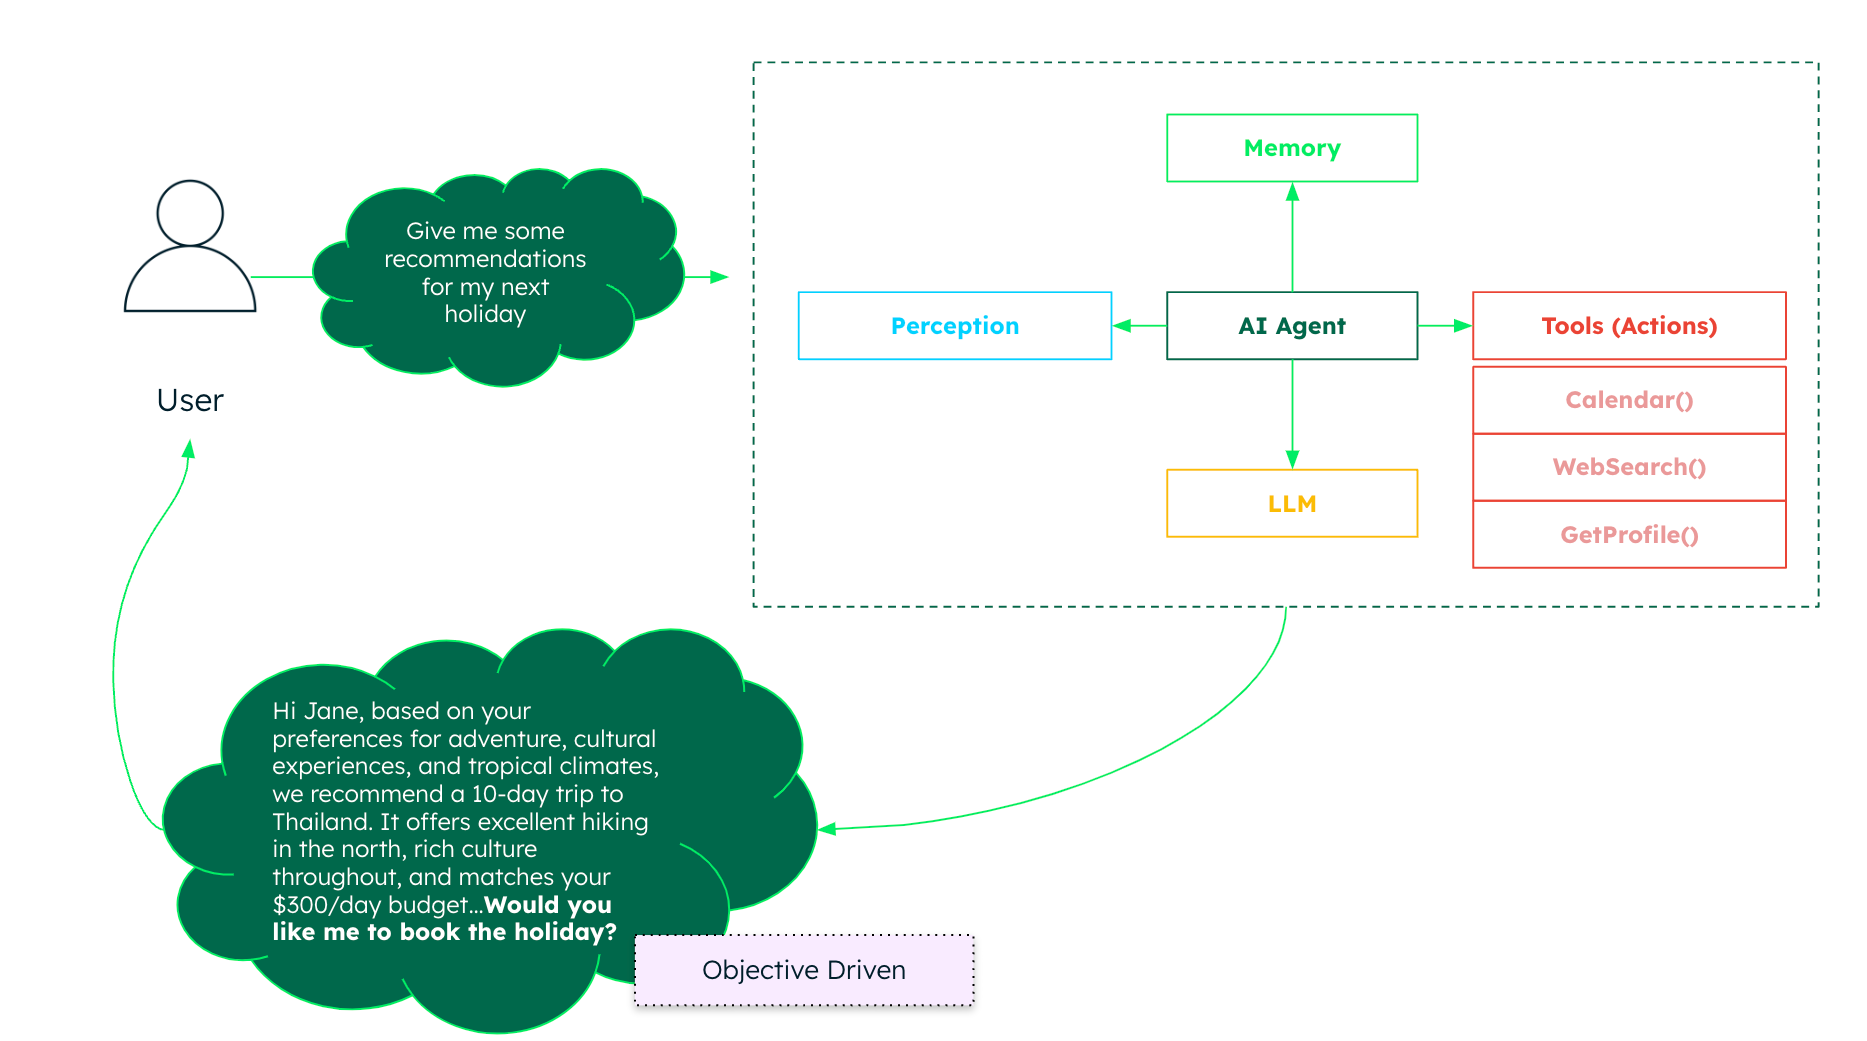

Tools are a mechanim to extend an agents capabilities in ways that supersedes the limitation of instructions/information provided through system prompts.

**Below are the key features of tools in PydanticAI**

- Context Awareness: Tools can be either context-aware `(@agent.tool)` or context-free `(@agent.tool_plain)`
- Type Safety: Tools leverage Python's type hints for parameter validation
- Automatic Documentation: Function docstrings are automatically used to build tool schemas
- Flexible Registration: Tools can be registered via decorators or through the Agent constructor

There are three primary methods to create tools in PydanticAI:

1. Using `@agent.tool` Decorator: Tools that need access to dependencies or context (like database connections, API clients). Ideal for most production scenarios where you need to manage resources or maintain state.

2. Using `@agent.tool_plain` Decorator:
Best for: Stateless utilities or simple computations that don't require context or dependencies. Perfect for pure functions like calculations or text processing.

3. Via the tools Parameter in Agent Constructor: Reusing existing functions as tools across different agents or when you need more control over tool configuration. Useful in scenarios where you're building multiple agents that share common functionality.


Each method trades off between simplicity and flexibility:

- Decorators offer the cleanest syntax and are most commonly used across other similar Agentic Frameworks
- Plain tools are perfect for simple, context-free operations
- Constructor injection provides the most flexibility for tool reuse and configuration

Choose based on your specific needs - whether you need context access, plan to reuse the tool, or prefer a certain style of code organization.

We will be implementing all three variaties in the section below




In [29]:
from dataclasses import dataclass

from pydantic_ai import Agent, RunContext, Tool


@dataclass
class MongoDeps:
    mongo_client = get_mongo_client(MONGO_URI)
    db = mongo_client[DB_NAME]
    knowledge_base = db[COLLECTION_NAME]

Connection to MongoDB successful


In [30]:
def retrieve_information_from_knowledge_base(
    ctx: RunContext[MongoDeps], user_query
) -> str:
    """
    Retrieves relevant information from the knowledge base based on the user's query.
    Performs a vector search using the provided `user_query` against the `knowledge_base` collection.
    """
    results, execution_time_ms = custom_vector_search(
        [user_query], ctx.deps.knowledge_base
    )
    return str(results)

In [31]:
toolbox = [Tool(retrieve_information_from_knowledge_base, takes_ctx=True)]

# The option below is also a viable tool implementation, without ability to specify context utilization or not
# toolbox = [retrieve_information_from_knowledge_base]

In [32]:
agent = Agent(
    model,
    system_prompt=("You get the latest news based on a user query"),
    deps_type=MongoDeps,
    tools=toolbox,
    result_retries=3,
)

In [33]:
results = agent.run_sync(
    "Get me some news on electric cars if possible", deps=MongoDeps
)
print(results.data)

Here are some recent news articles on electric cars:

1. **SK signet Inks Deal with Francis Energy for the Supply of Ultra-Fast EV Chargers to the US**  
   SK Signet has signed a deal with Francis Energy for an order of more than 1000 EV chargers. Francis Energy is currently the fourth-largest fast charger operator in the United States.  
   [Read more](https://www.econotimes.com/SK-signet-Inks-Deal-with-Francis-Energy-for-the-Supply-of-Ultra-Fast-EV-Chargers-to-the-US-1659601) (Published on 2023-07-18)

2. **YS Tech working closely with China car vendors**  
   Automotive cooling fan supplier Yen Sun Technology (YS Tech) is working closely with Chinese customers and anticipates a new Chinese government policy to boost the country's EV sector.  
   [Read more](https://www.digitimes.com/news/a20230309PD211/automotive-china-ev+green-energy-ys-tech.html) (Published on 2023-03-10)

3. **Investing in Cleaner Technology: Lesser-Known Areas of Innovation to Watch**  
   This article discusse

In [34]:
# You can get a Tavily API Key here: https://app.tavily.com/home
set_env_securely("TAVILY_API_KEY", "Enter your Tavily API key: ")

Enter your Tavily API key: ··········


In [35]:
# Create the collection if it doesn't exist
if "working_memory" not in db.list_collection_names():
    working_memory = db.create_collection("working_memory")
    print("Collection 'working_memory' created successfully.")
else:
    working_memory = db["working_memory"]
    print("Collection 'working_memory' already exists.")

Collection 'working_memory' created successfully.


In [36]:
working_memory_vector_index_definition = create_vector_index_definition()

In [37]:
setup_vector_search_index(
    working_memory, working_memory_vector_index_definition, "vector_index"
)

Creating index 'vector_index'...
Waiting for 60 seconds to allow index 'vector_index' to be created...
Error creating new vector search index 'vector_index': 'float' object has no attribute 'sleep'


In [38]:
working_memory.delete_many({})

DeleteResult({'n': 0, 'electionId': ObjectId('7fffffff000000000000003a'), 'opTime': {'ts': Timestamp(1736447917, 1), 't': 58}, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1736447917, 1), 'signature': {'hash': b'Y\xd1\x15\xa32fD\x0fx\xaf\xbbp\x13\x19\xb1QR)~\xf7', 'keyId': 7421923411288391683}}, 'operationTime': Timestamp(1736447917, 1)}, acknowledged=True)

In [39]:
from datetime import datetime


class WorkingMemoryData(BaseModel):
    content: str
    site_title: str
    site_url: str
    added_at: datetime = Field(default_factory=datetime.utcnow)
    embedding: List[float] = Field(
        ..., description="The embedding vector for the news article"
    )

In [40]:
def my_ranking_function(query, documents, top_n):
    return documents

In [41]:
from datetime import datetime


def save_document(document: dict) -> Optional[WorkingMemoryData]:
    """
    Processes a document and converts it to a WorkingMemoryData instance.

    Args:
      document: A dictionary containing the raw document data

    Returns:
      WorkingMemoryData instance if document meets criteria, None otherwise
    """
    # First check the score threshold
    if document["score"] < 0.5:
        return None

    # Generate embeddings for the content
    embedding_vector = get_embeddings([document["content"]])[0]

    try:
        # Create a WorkingMemoryData instance with validation
        processed_document = WorkingMemoryData(
            content=document["content"],
            site_title=document["title"],
            site_url=document["url"],
            embedding=embedding_vector,
            # added_at will be set automatically by default_factory
        )

        return processed_document.dict()

    except ValueError as e:
        # Handle any validation errors from Pydantic
        print(f"Error creating WorkingMemoryData: {e}")
        return None

In [42]:
from tavily import TavilyHybridClient

# Documentation on the hybridrag client: https://docs.tavily.com/docs/python-sdk/tavily-hybrid-rag/getting-started
hybrid_rag = TavilyHybridClient(
    api_key=os.environ.get("TAVILY_API_KEY"),
    db_provider="mongodb",
    collection=working_memory,
    index="vector_index",
    embedding_function=get_embeddings,
    embeddings_field="embedding",
    content_field="description",
    ranking_function=my_ranking_function,
)

In [43]:
query = "Get me some news on electric cars if possible"
internet_search_results = hybrid_rag.search(query)

In [44]:
pprint.pprint(internet_search_results)

[{'content': 'Photo Galleries\n'
             'Most Popular\n'
             'Motor Authority Newsletter\n'
             'Sign up to get the latest performance and luxury automotive '
             'news, delivered to your inbox daily!\n'
             ' Electric Cars\n'
             'The AMG version of the EQE SUV doesn’t have the fire and fury of '
             'other models from Mercedes’ performance arm.\n'
             ' Will the jump-started VW brand really bring out a new '
             'Aristocrat, or is just protecting IP?\n'
             'VW is working on an electric GTI but it might not be '
             'Golf-based.\n'
             ' The 1,234-hp Lucid Air Sapphire is the quickest car ever to '
             'grace the MA Best Car To Buy competition.\n'
             ' The 964 RSR is a dream car for 911 fans of a certain age, and '
             'Everrati is looking to capitalize with an electric tribute.\n',
  'origin': 'foreign',
  'score': 0.7156829},
 {'content': 'Electric Ca

In [45]:
query = "Get me some news on electric cars if possible"
max_foreign = 5
max_local = 5

internet_search_results = hybrid_rag.search(
    query, max_local=max_local, max_foreign=max_foreign, save_foreign=save_document
)

<ipython-input-41-18507b6d9b9a>:30: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return processed_document.dict()


In [46]:
pprint.pprint(internet_search_results)

[{'content': 'Photo Galleries\n'
             'Most Popular\n'
             'Motor Authority Newsletter\n'
             'Sign up to get the latest performance and luxury automotive '
             'news, delivered to your inbox daily!\n'
             ' Electric Cars\n'
             'The AMG version of the EQE SUV doesn’t have the fire and fury of '
             'other models from Mercedes’ performance arm.\n'
             ' Will the jump-started VW brand really bring out a new '
             'Aristocrat, or is just protecting IP?\n'
             'VW is working on an electric GTI but it might not be '
             'Golf-based.\n'
             ' The 1,234-hp Lucid Air Sapphire is the quickest car ever to '
             'grace the MA Best Car To Buy competition.\n'
             ' The 964 RSR is a dream car for 911 fans of a certain age, and '
             'Everrati is looking to capitalize with an electric tribute.\n',
  'origin': 'foreign',
  'score': 0.7156829},
 {'content': 'Electric Ca

In [47]:
@agent.tool_plain
def get_search_results_from_internet_search(user_query):
    """Use Tavily to get search results from the internet."""
    return hybrid_rag.search(
        user_query,
        max_local=max_local,
        max_foreign=max_foreign,
        save_foreign=save_document,
    )

In [138]:
# from tavily import TavilyClient

# tavily_client = TavilyClient(api_key=os.environ.get("TAVILY_API_KEY"))

# @agent.tool_plain
# def extract_data_from_urls(urls):
#   """ Extract content from a urls in a given list """
#   return tavily_client.extract(urls=urls, include_images=False)

In [48]:
results = agent.run_sync(
    "Get me some news on electric cars if possible", deps=MongoDeps
)
print(results.data)

<ipython-input-41-18507b6d9b9a>:30: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  return processed_document.dict()


Here is some recent news on electric cars:

1. **SK Signet Inks Deal with Francis Energy for Ultra-Fast EV Chargers:**
   - **Date:** July 18, 2023
   - **Details:** SK Signet signed a deal with Francis Energy to supply more than 1000 ultra-fast EV chargers in the US. Francis Energy is currently the fourth-largest fast charger operator in the United States.
   - [Read more](https://www.econotimes.com/SK-signet-Inks-Deal-with-Francis-Energy-for-the-Supply-of-Ultra-Fast-EV-Chargers-to-the-US-1659601)

2. **YS Tech Working Closely with Chinese Car Vendors:**
   - **Date:** March 10, 2023
   - **Details:** Automotive cooling fan supplier YS Tech is collaborating with Chinese customers and is anticipating a new Chinese government policy to boost its EV sector.
   - [Read more](https://www.digitimes.com/news/a20230309PD211/automotive-china-ev+green-energy-ys-tech.html)

3. **MotorTrend's New Electric Car Models:**
   - 2025 Dodge Charger Sixpack is reportedly fast-tracked.
   - New models li

In [49]:
results.all_messages()

[ModelRequest(parts=[SystemPromptPart(content='You get the latest news based on a user query', dynamic_ref=None, part_kind='system-prompt'), UserPromptPart(content='Get me some news on electric cars if possible', timestamp=datetime.datetime(2025, 1, 9, 18, 39, 45, 435371, tzinfo=datetime.timezone.utc), part_kind='user-prompt')], kind='request'),
 ModelResponse(parts=[ToolCallPart(tool_name='retrieve_information_from_knowledge_base', args=ArgsJson(args_json='{"user_query": "electric cars news"}'), tool_call_id='call_c10S8UWOpb2Pxn8U56W4sLvm', part_kind='tool-call'), ToolCallPart(tool_name='get_search_results_from_internet_search', args=ArgsJson(args_json='{"user_query": "electric cars news"}'), tool_call_id='call_xcF2cH3F4K9glpRLCAJo0Q44', part_kind='tool-call')], timestamp=datetime.datetime(2025, 1, 9, 18, 39, 45, tzinfo=datetime.timezone.utc), kind='response'),
 ModelRequest(parts=[ToolReturnPart(tool_name='retrieve_information_from_knowledge_base', content='[{\'companyName\': \'01Syn